# Exercise 2: Differences between data sets

## check dataset Ocean-atmosphere heat flux climatology

In [61]:
import xarray as xr
import matplotlib.pyplot as plt

path = "/Users/macbookstephan/Library/Mobile Documents/com~apple~CloudDocs/AA Studium/Master/APOTHERM/Exercises/H2_Ocean_atmosphere_heat_flux_climatology.nc"

# cftime-safe open pattern
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

ds = xr.open_dataset(path, decode_times=False)
dheat = ds

dheat

<xarray.Dataset> Size: 3MB
Dimensions:  (X: 360, T: 12, Y: 170)
Coordinates:
  * X        (X) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * T        (T) float32 48B 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * Y        (Y) float32 680B -84.5 -83.5 -82.5 -81.5 ... 81.5 82.5 83.5 84.5
Data variables:
    hfns     (T, Y, X) float32 3MB ...
Attributes:
    Conventions:  COARDS

## plot heat flux near surface

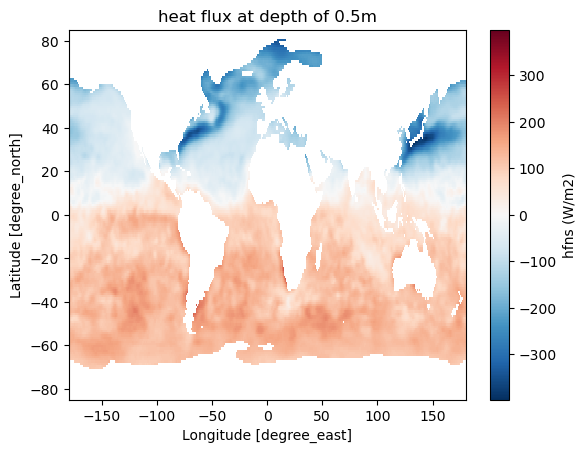

In [64]:
varname = "hfns" 
#if "hfns" in dheat.data_vars else next(iter(dheat.data_vars))

# plot
ax = dheat[varname].isel(T=0).plot(
    cmap="RdBu_r",
    cbar_kwargs={"label": f"{varname} ({dheat[varname].attrs.get('units', '')})"}
)
ax.axes.set_title(f"heat flux at depth of {dheat['T'].values[0]}m")
plt.show()


## check dataset Levitus climatology

In [87]:
ds = xr.open_dataset('/Users/macbookstephan/Library/Mobile Documents/com~apple~CloudDocs/AA Studium/Master/APOTHERM/Exercises/H2_Levitus_climatology.nc', decode_times=False)
dlev = ds                                            
dlev

<xarray.Dataset> Size: 59MB
Dimensions:  (T: 12, Y: 180, Z: 19, X: 360)
Coordinates:
  * T        (T) float32 48B 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * Y        (Y) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 76B 0.0 10.0 20.0 30.0 50.0 ... 700.0 800.0 900.0 1e+03
  * X        (X) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    temp     (T, X, Y, Z) float32 59MB ...

## check MIMOC dataset

In [223]:
dmim = xr.open_dataset(
    "/Users/macbookstephan/Library/Mobile Documents/com~apple~CloudDocs/AA Studium/Master/APOTHERM/Exercises/H2_MIMOC_Z_GRID_v2.2_PT_S_month01.nc",
    decode_times=False
)

smedian = float(dmim["SALINITY"].median().values)
print(f"Median salinity: {smedian:.3f}")
dmim

Median salinity: 34.650


<xarray.Dataset> Size: 159MB
Dimensions:                (LAT: 341, LONG: 720, PRES: 81)
Dimensions without coordinates: LAT, LONG, PRES
Data variables:
    LATITUDE               (LAT) float32 1kB ...
    LONGITUDE              (LONG) float32 3kB ...
    PRESSURE               (PRES) float32 324B ...
    SALINITY               (PRES, LAT, LONG) float32 80MB nan nan ... 34.93
    POTENTIAL_TEMPERATURE  (PRES, LAT, LONG) float32 80MB ...

## plot potential temperature at depth of 700m for Levitus and MIMOC

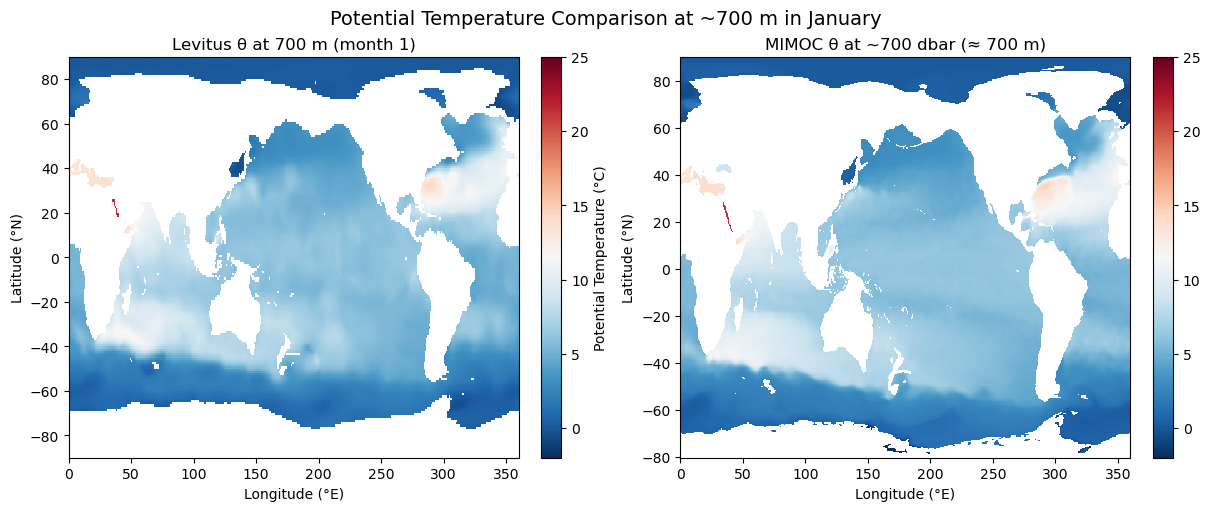

In [186]:
import xarray as xr
import seawater as sw

# MIMOC setup
# normalize LONG to 0–360°
dmim = dmim.assign_coords({
    "LAT":  ("LAT",  dmim["LATITUDE"].values),
    "LONG": ("LONG", dmim["LONGITUDE"].values % 360),
    "PRES": ("PRES", dmim["PRESSURE"].values),
})

# Select ~700 dbar (≈ 700 m)
p_target = 700.0
iP = int(np.abs(dmim["PRES"].values - p_target).argmin())
p_sel = float(dmim["PRES"].values[iP])
theta_700_mim = dmim["POTENTIAL_TEMPERATURE"].isel(PRES=iP)  # (LAT, LONG)

# Levitus: compute θ with constant median salinity from MIMOC
month = 0
target_depth = p_target  # 700 m ~ 700 dbar
level_dlev = int(np.abs(dlev["temp"].Z.values - target_depth).argmin())
z_sel = float(dlev["temp"].Z.values[level_dlev])

# In-situ temperature at that month and depth
T = dlev["temp"].isel(T=month, Z=level_dlev)

S_MED = 34.65 # PSU
S = xr.full_like(T, S_MED)

# Pressure in dbar 
P_lev = float(dlev["temp"]["Z"].values[level_dlev])

# Compute potential temperature θ
theta_dlev = xr.apply_ufunc(
    lambda s, t: sw.ptmp(s, t, P_lev, 0.0),
    S, T,
    vectorize=True
)

# Plot comparison maps
vmin, vmax = -2, 25
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Levitus θ
theta_dlev.plot(
    ax=axes[0], x="X", y="Y",
    cmap="RdBu_r", vmin=vmin, vmax=vmax,
    cbar_kwargs={"label": "Potential Temperature (°C)"}
)
axes[0].set_title(f"Levitus θ at {z_sel:.0f} m (month {month+1})")
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Latitude (°N)")

# MIMOC θ (~700 dbar)
theta_700_mim.plot(
    ax=axes[1], x="LONG", y="LAT",
    cmap="RdBu_r", vmin=vmin, vmax=vmax,
    cbar_kwargs={"label": ""}
)
axes[1].set_title(f"MIMOC θ at ~{p_sel:.0f} dbar (≈ {p_sel:.0f} m)")
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Latitude (°N)")

plt.suptitle("Potential Temperature Comparison at ~700 m in January", fontsize=14)
plt.show()


## Explanation:
Different longitude range:	dmim["LONGITUDE"].values % 360 converts −180–180 → 0–360  
Different variable names:	Use consistent plotting (LONG/LAT for MIMOC, X/Y for Levitus)  
Salinity for Levitus:       take the median of MIMOC salinity (34.65 PSU)  
Potential temperature:      import module 'seawater'  
Units (pressure vs depth):	700 dbar ≈ 700 m — negligible difference for this scale  
Comparison:               	Both plots use same color scale (vmin=-2, vmax=30)  

## plot Levitus and MIMOC potential temperature at 700m restricted to Labrador and Irminger Seas

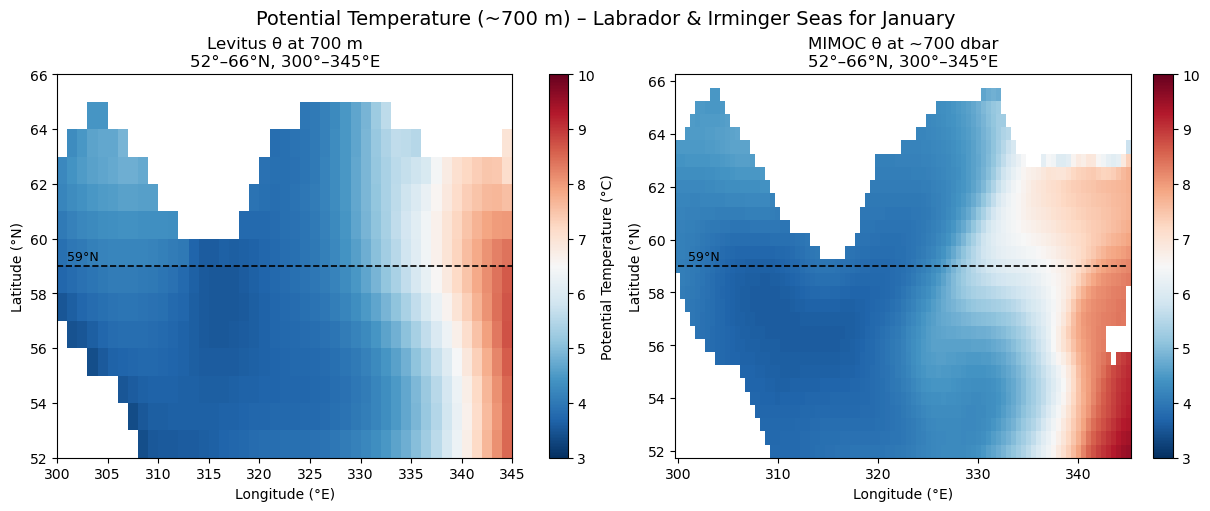

In [230]:
# Region: Labrador & Irminger Sea (0–360°)
lat_min, lat_max = 52, 66
lat_section = 59.0  # for next subtask
lon_min, lon_max = 300, 345

# Subset both θ fields to the region
theta_lev_reg = theta_dlev.sel(Y=slice(lat_min, lat_max), X=slice(lon_min, lon_max))          # Levitus θ (Y,X)
theta_mim_reg = theta_700_mim.sel(LAT=slice(lat_min, lat_max), LONG=slice(lon_min, lon_max))  # MIMOC θ (LAT,LONG)

# Shared color range
vmin, vmax = 3, 10

# Plot: MIMOC and Levitus with aligned grids and shared color scale
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Levitus θ
theta_lev_reg.plot(
    ax=axes[0], x="X", y="Y",
    cmap="RdBu_r", vmin=vmin, vmax=vmax,
    cbar_kwargs={"label": "Potential Temperature (°C)"}
)
axes[0].set_title(f"Levitus θ at {z_sel:.0f} m\n{lat_min}°–{lat_max}°N, {lon_min}°–{lon_max}°E")
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Latitude (°N)")

# highlight latitude 59°
axes[0].hlines(lat_section, lon_min, lon_max, colors='k', linestyles='--', linewidth=1.2)
axes[0].text(lon_min + 1, lat_section + 0.2, f"{lat_section:.0f}°N", color='k', fontsize=9)

# MIMOC θ (~700 dbar)
theta_mim_reg.plot(
    ax=axes[1], x="LONG", y="LAT",
    cmap="RdBu_r", vmin=vmin, vmax=vmax,
    cbar_kwargs={"label": ""}
)
axes[1].set_title(f"MIMOC θ at ~{p_sel:.0f} dbar\n{lat_min}°–{lat_max}°N, {lon_min}°–{lon_max}°E")
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Latitude (°N)")

# highlight latitude 59°
axes[1].hlines(lat_section, lon_min, lon_max, colors='k', linestyles='--', linewidth=1.2)
axes[1].text(lon_min + 1, lat_section + 0.2, f"{lat_section:.0f}°N", color='k', fontsize=9)

plt.suptitle("Potential Temperature (~700 m) – Labrador & Irminger Seas for January", fontsize=14)
plt.show()


## plot vertical profile of Potential Temperature at 59° North

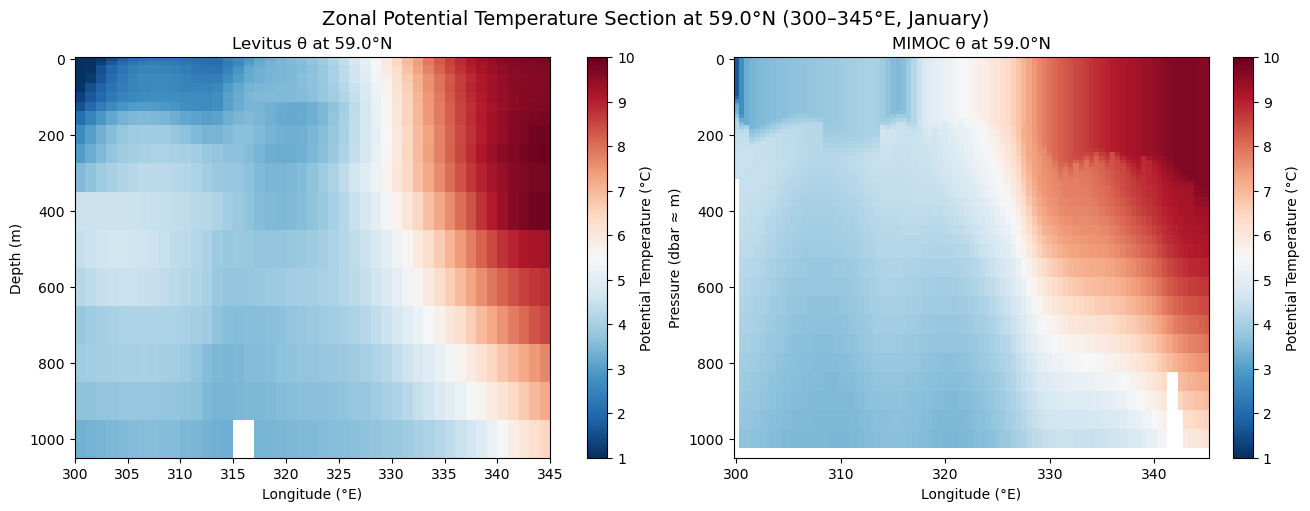

In [193]:
# settings
lat_target = 59.0      # section latitude
use_interp = True      # use bilinear interpolation for smoother slice

# MIMOC θ
theta_mim = dmim["POTENTIAL_TEMPERATURE"]

# Interpolate / select at given latitude
theta_mim_lat = (
    theta_mim.interp(LAT=lat_target) 
    if use_interp else theta_mim.sel(LAT=lat_target, method="nearest")
).sel(LONG=slice(lon_min, lon_max))

# Limit to the same max depth as Levitus (≈ 1000 m)
max_depth_lev = float(dlev["temp"]["Z"].max())
theta_mim_lat = theta_mim_lat.sel(PRES=slice(0, max_depth_lev))

# Ensure (PRES, LONG) order for plotting
theta_mim_lat = theta_mim_lat.transpose("PRES", "LONG")

# Extract coordinates
pres_mim = theta_mim_lat["PRES"]     
lon_mim  = theta_mim_lat["LONG"]

# LEVITUS Potential Temperature with S=34.65
temp_lev = dlev["temp"]

# Build in-situ T section (Z,X) at target latitude
temp_lev_lat = (                                                  
    temp_lev.isel(T=month).interp(Y=lat_target)                 
    if use_interp else temp_lev.isel(T=month).sel(Y=lat_target, method="nearest")
).sel(X=slice(lon_min, lon_max)).transpose("Z", "X")        

# Fixed salinity
S_lev_lat = xr.full_like(temp_lev_lat, 34.65)               

# Pressure vector (dbar) from depth, broadcasts over X
Zvec = temp_lev_lat["Z"]                                        

# Compute potential temperature θ at PR=0 dbar → (Z, X)
theta_lev_lat = xr.apply_ufunc(                                
    sw.ptmp, S_lev_lat, temp_lev_lat, Zvec, 0.0, vectorize=True
)

# Extract coordinates
z_lev   = theta_lev_lat["Z"]                                  
lon_lev = theta_lev_lat["X"]                           

# Plot 59° North
fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

# Levitus θ
im1 = axes[0].pcolormesh(
    lon_lev, z_lev, theta_lev_lat.values,                       
    cmap="RdBu_r", vmin=vmin, vmax=vmax, shading="auto"
)
axes[0].invert_yaxis()
axes[0].set_title(f"Levitus θ at {lat_target:.1f}°N")   
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Depth (m)")
plt.colorbar(im1, ax=axes[0], label="Potential Temperature (°C)") 

# MIMOC
im2 = axes[1].pcolormesh(
    lon_mim, pres_mim, theta_mim_lat.values,
    cmap="RdBu_r", vmin=vmin, vmax=vmax, shading="auto"
)
# match y-axis orientation & range to Levitus panel
axes[1].set_ylim(*axes[0].get_ylim())
axes[1].set_title(f"MIMOC θ at {lat_target:.1f}°N")
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Pressure (dbar ≈ m)")
plt.colorbar(im2, ax=axes[1], label="Potential Temperature (°C)")

plt.suptitle(f"Zonal Potential Temperature Section at {lat_target:.1f}°N (300–345°E, January)", fontsize=14)
plt.show()



## Explanation:

Longitude range: 300-345° East  
Latitude: 59° North  
Depth: Limit MIMOC depth at 1000 dbar ≈ 1000m  

## plot integrated heat content between 0-1000m

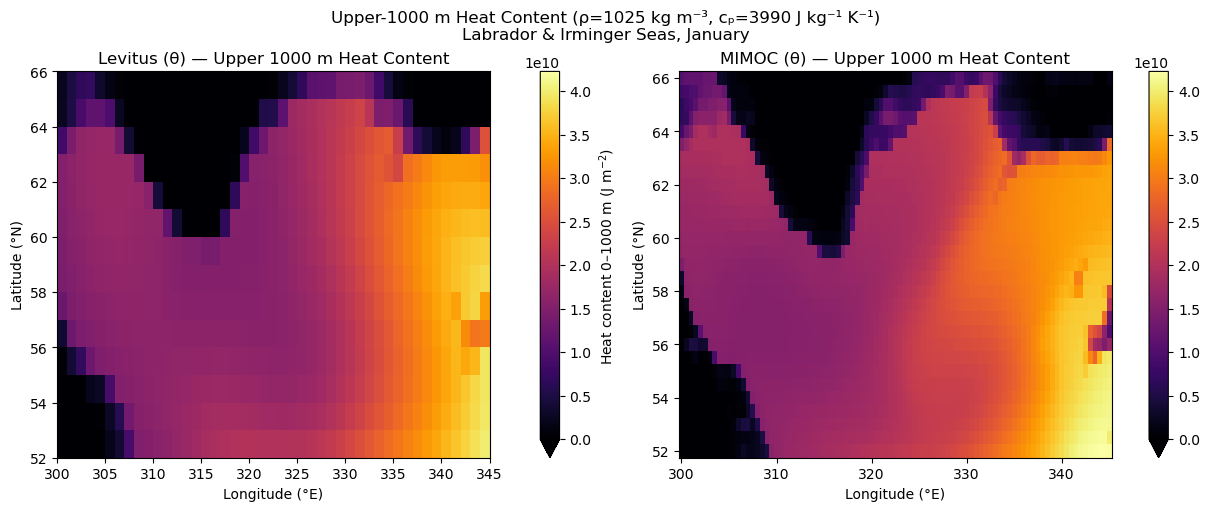

In [219]:
import numpy as np

# settings / region 
month = 0  # January
lat_min, lat_max = 52, 66
lon_min, lon_max = 300, 345
Z_MAX = 1000.0
rho = 1025.0   # kg/m^3
cp  = 3990.0   # J/(kg·K)

# Levitus: θ with fixed S=34.65 across the full map
T4 = dlev["temp"].isel(T=month)         # 3 dimensions 
Z1 = T4["Z"]                            # 1 dimension
S4 = xr.full_like(T4, 34.65)
Z3 = xr.broadcast(T4, Z1)[1]

theta_lev = xr.apply_ufunc(sw.ptmp, S4, T4, Z3, 0.0, vectorize=True)

# restrict to 0–1000 m and region
theta_lev_1000 = theta_lev.sel(Z=slice(0, Z_MAX)).sel(Y=slice(lat_min, lat_max), X=slice(lon_min, lon_max))
Zsub = theta_lev_1000["Z"]

# integrate layer (m) along Z 
dz = xr.zeros_like(Zsub)
dz[0]        = Zsub[1] - Zsub[0]
dz[1:-1]     = (Zsub[2:].values - Zsub[:-2].values)/2.0
dz[-1]       = Zsub[-1] - Zsub[-2]

HC_lev = (rho*cp * (theta_lev_1000 * dz).sum("Z"))  # J m^-2, (Y,X)

# MIMOC: θ provided by dataset
theta_mim = dmim["POTENTIAL_TEMPERATURE"]   # (PRES,LAT,LONG)
PRES = dmim["PRES"]

# restrict to 0–1000 m and region
theta_mim_1000 = theta_mim.sel(PRES=slice(0, Z_MAX)).sel(LAT=slice(lat_min, lat_max), LONG=slice(lon_min, lon_max))
Psub = theta_mim_1000["PRES"]  # dbar ≈ m

# integrate layer (m) along PRES
dp = xr.zeros_like(Psub)
dp[0]        = Psub[1] - Psub[0]
dp[1:-1]     = (Psub[2:].values - Psub[:-2].values)/2.0
dp[-1]       = Psub[-1] - Psub[-2]

HC_mim = (rho*cp * (theta_mim_1000 * dp).sum("PRES"))  # J m^-2, (LAT,LONG)

# plot maps with shared color scale
vmax_shared = float(xr.concat(
    [HC_lev, HC_mim.rename({"LAT":"Y", "LONG":"X"})], dim="stack"
).max().values)
vmin_shared = 0.0

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Levitus heat content map 
HC_lev.plot(
    ax=axes[0], x="X", y="Y",
    cmap="inferno", vmin=vmin_shared, vmax=vmax_shared,
    cbar_kwargs={"label": "Heat content 0–1000 m (J m$^{-2}$)"}
)
axes[0].set_title("Levitus (θ) — Upper 1000 m Heat Content")
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Latitude (°N)")

# MIMOC heat content map 
HC_mim.plot(
    ax=axes[1], x="LONG", y="LAT",
    cmap="inferno", vmin=vmin_shared, vmax=vmax_shared,
    cbar_kwargs={"label": ""}
)
axes[1].set_title("MIMOC (θ) — Upper 1000 m Heat Content")
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Latitude (°N)")

plt.suptitle("Upper-1000 m Heat Content (ρ=1025 kg m⁻³, cₚ=3990 J kg⁻¹ K⁻¹)\nLabrador & Irminger Seas, January", fontsize=12)
plt.show()



## Explanation:

integrate over Z across different depth layers 